In [6]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

In [7]:
os.environ['KAGGLE_USERNAME'] = 'jinyeong29' # username
os.environ['KAGGLE_KEY'] = 'd34c54a6dadccabe3a3232fdd28e8507' # key

In [8]:
!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
!unzip -q cats_and_dogs_filtered.zip  # 다운로드 및 압축 풀기

--2023-06-20 04:51:41--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.251.10.128, 142.251.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip.3’

cats_and_dogs_filte 100%[===================>]  65.43M  20.2MB/s    in 3.4s    

2023-06-20 04:51:44 (19.3 MB/s) - ‘cats_and_dogs_filtered.zip.3’ saved [68606236/68606236]

replace cats_and_dogs_filtered/vectorize.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device) # GPU로 사용

cuda


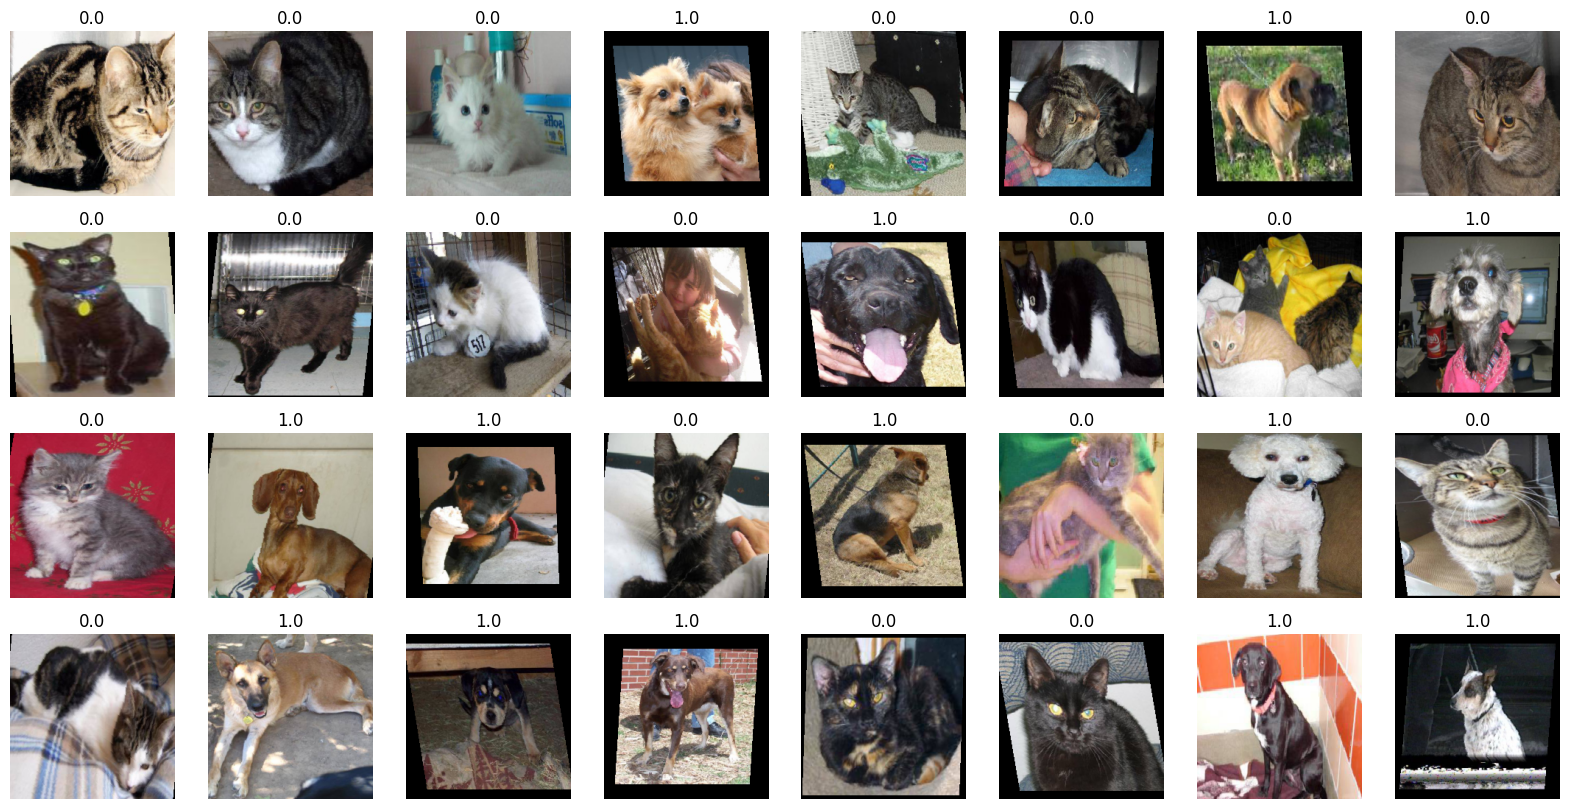

In [13]:
data_transforms = {
    'train': transforms.Compose([                                 # * 여러개의 데이터 변환을 순차적으로 적용하기 위한 변환 객체
        transforms.Resize((224, 224)),   # 이미지 크기 224 * 224
        transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)), # 무작위 아핀변환, 수평/수직으로 10도 전환 변환을 적용 / 이미지 크기를 0.8 ~ 1.2배 랜덤 조정
        transforms.RandomHorizontalFlip(), # 무작위 수평 뒤집기 전환, 50% 확률로 수평으로 뒤집음
        transforms.ToTensor() # 파이토치의 텐서로 변환
    ]),
    'validation': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}


def target_transforms(target):  # 주어진 타겟값을 floatTensor 형식으로 변환하는 함수
    return torch.FloatTensor([target]) # target을 받아들이고, torch.FloatTensor를 반환


image_datasets = { # 이미지 데이터셋 딕셔너리
    'train': datasets.ImageFolder('cats_and_dogs_filtered/train', data_transforms['train'], target_transform=target_transforms), # 훈련 데이터셋, cats_and_dogs_filtered/train 경로에서 이미지 데이터를 로드, 이때 데이터 변환은 data_transforms['train']에 정의된 변환들이 적용됨, 타겟 변수를 원하는 형식으로 변환
    'validation': datasets.ImageFolder('cats_and_dogs_filtered/validation', data_transforms['validation'], target_transform=target_transforms)
}
dataloaders = {
    'train': DataLoader(
        image_datasets['train'],        # 이 데이터 셋에 로드
        batch_size=32,           # 한 번에 로드 할 수 있는 배치 크기 지정, 32로 설정됨
        shuffle=True  # epoch 단위로 무작위로 섞을지 여부 = > V
    ),
    'validation': DataLoader(
        image_datasets['validation'],
        batch_size=32,
        shuffle=False # 데이터를 섞지 않음
    )
}


imgs, labels = next(iter(dataloaders['train'])) # train 데이터로더에서 이미지와 레이블을 가져옴
fig, axes = plt.subplots(4, 8, figsize=(20, 10)) # 레이블은 4행 8열, 20*10 크기
for img, label, ax in zip(imgs, labels, axes.flatten()): # zip 함수를 사용하여, img, label, axes.flatten을 함께 묶은 후 순회
    ax.set_title(label.item()) # 해당 하위 그림의 제목을 해당 이미지의 레이블 값으로 설정
    ax.imshow(img.permute(1, 2, 0)) # 이미지의 차원 순서를 변경, 이미지를 올바른 형식으로 표현하는데 사용 / Tensor의 차원 :: (높이/너비/채널)
    ax.axis('off') # 축은 표현하지 않음


# model = models.resnet50(pretrained = True).to(device)
model = models.resnet50(weights = 'IMAGENET1K_V1').to(device) # resnet50 아키텍쳐 사용, torchvision의 models 모듈에서 가져와, model이라는 변수에 할당 / weights이라는 매개변수를 IMAGENET1K_V1으로 설정, 사전 학습된 Image 데이터셋으로 미리 학습된 가중치를 적용 -> gpu로 이동
for param in model.parameters(): # 모든 파라미터를 순회
  param.requires_grad = False # 가져온 파라미터 (W,b)를 업데이트 하지 않음
  model.fc = nn.Sequential( # model.fc라는 변수에, pytorch의 모듈을 순차적으로 연결 및 신경망 모델을 구성하기 위한 컨테이너(nn.Sequential에 대한 설명)
      nn.Linear(2048, 128), # 선형 레이어, 입력 크기가 2048, 출력 크기가 128인 선형 변환을 정의
      nn.ReLU(), # pytorch에서 활성화 함수를 나타내는 모듈, 신경망이 복잡한 함수를 모델링
      nn.Linear(128, 1),  # 크기가 128, 출력 크기가 1인 선형 변환을 정의하는 모듈
      nn.Sigmoid() # 출력값을 0과 1으로 제한해 이진 분류의 확률로 해석
  ).to(device)

In [14]:
# 학습: fc 부분만 학습하므로 속도가 빠름
optimizer = optim.Adam(model.fc.parameters(), lr = 0.001) # Adam(Optimizer)를 사용하여 model.fc에 속한 파라미터를 업데이트하는 optimizer를 설정하는 부분, 학습률은 0.001 / 학습률은 각 파라미터 업데이트 시 곱해지는 스케일링 인자로, 파라미터 업데이트의 속도를 조절
epochs = 10
for epoch in range(epochs):
  for phase in ['train','validation']:
    if phase == 'train':
      model.train()
    else:
      model.eval()
    sum_losses = 0
    sum_accs = 0
    for x_batch, y_batch in dataloaders[phase]:
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)
      y_pred = model(x_batch)
      loss = nn. BCELoss()(y_pred, y_batch)
      if phase == 'train':
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
      sum_losses = sum_losses + loss.item()
      y_bool = (y_pred >= 0.5).float()
      acc = (y_batch == y_bool).float().sum() / len(y_batch) * 100
      sum_accs = sum_accs + acc.item()
    avg_loss = sum_losses / len(dataloaders[phase])
    avg_acc = sum_accs / len(dataloaders[phase])
    print(f'{phase:10s}: Epoch {epoch+1:4d}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.2f}%')

train     : Epoch    1/10, Loss: 0.3275, Accuracy: 85.07%
validation: Epoch    1/10, Loss: 0.0907, Accuracy: 98.14%
train     : Epoch    2/10, Loss: 0.1143, Accuracy: 95.88%
validation: Epoch    2/10, Loss: 0.0734, Accuracy: 97.75%
train     : Epoch    3/10, Loss: 0.0806, Accuracy: 96.78%
validation: Epoch    3/10, Loss: 0.0442, Accuracy: 98.73%
train     : Epoch    4/10, Loss: 0.0684, Accuracy: 97.17%
validation: Epoch    4/10, Loss: 0.0684, Accuracy: 97.36%
train     : Epoch    5/10, Loss: 0.0665, Accuracy: 97.37%
validation: Epoch    5/10, Loss: 0.0411, Accuracy: 98.54%
train     : Epoch    6/10, Loss: 0.0778, Accuracy: 97.12%
validation: Epoch    6/10, Loss: 0.0376, Accuracy: 98.63%
train     : Epoch    7/10, Loss: 0.0635, Accuracy: 97.87%
validation: Epoch    7/10, Loss: 0.0297, Accuracy: 98.83%
train     : Epoch    8/10, Loss: 0.0897, Accuracy: 96.33%
validation: Epoch    8/10, Loss: 0.0300, Accuracy: 98.83%
train     : Epoch    9/10, Loss: 0.0649, Accuracy: 97.52%
validation: Ep

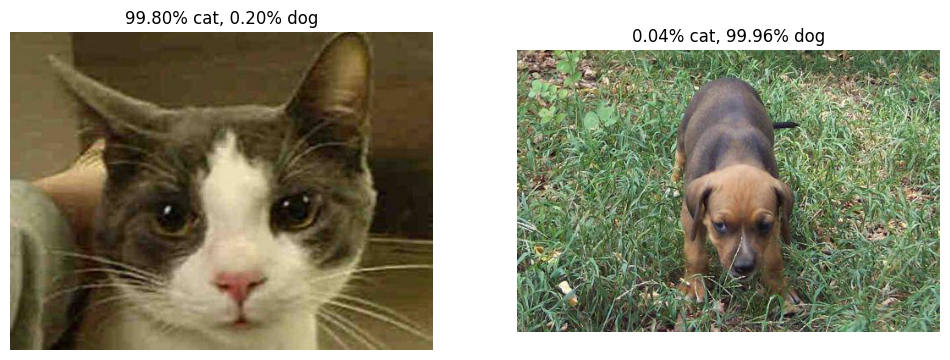

In [25]:
# 테스트
from PIL import Image
img1 = Image.open('/content/cats_and_dogs_filtered/validation/cats/cat.2200.jpg')
img2 = Image.open('/content/cats_and_dogs_filtered/validation/dogs/dog.2100.jpg')

img1_input = data_transforms['validation'](img1)
img2_input = data_transforms['validation'](img2)

test_batch = torch.stack([img1_input, img2_input])
test_batch = test_batch.to(device)

y_pred = model(test_batch)
fig, axes = plt.subplots(1,2,figsize = (12,6))

axes[0].imshow(img1)
axes[0].axis('off')
axes[0].set_title(f'{(1-y_pred[0,0]) * 100:.2f}% cat, {y_pred[0,0] * 100:.2f}% dog')  # 예측 정확도를 타이틀로 추가

axes[1].imshow(img2)
axes[1].axis('off')
axes[1].set_title(f'{(1-y_pred[1,0]) * 100:.2f}% cat, {y_pred[1,0] * 100:.2f}% dog')  # 예측 정확도를 타이틀로 추가

plt.show()